# Inference: Haario adaptive covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using a variant of [Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_ac_mcmc.html) detailed in algorithm 4 in [1] and in the text in [2].

[1] A tutorial on adaptive MCMC
    Christophe Andrieu and Johannes Thoms, Statistical Computing,
    2008, 18: 343-373.
    
[2] An adaptive Metropolis algorithm
    Heikki Haario, Eero Saksman, and Johanna Tamminen (2001) Bernoulli.

It follows on from the [first sampling example](./first-example.ipynb).

Running...
Done!


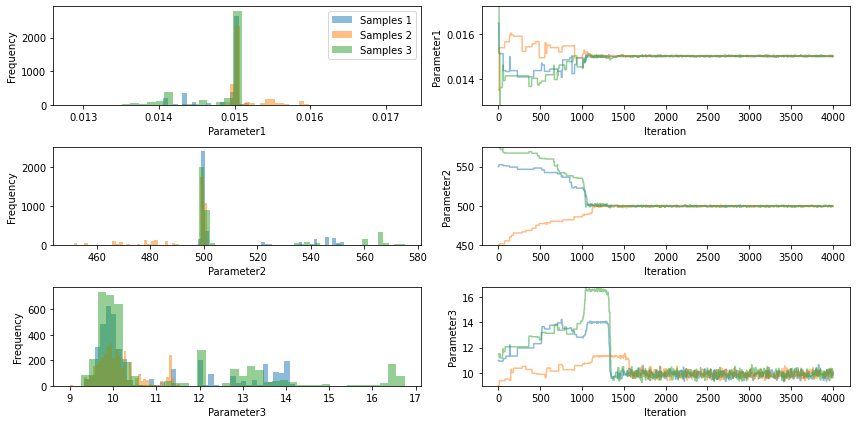

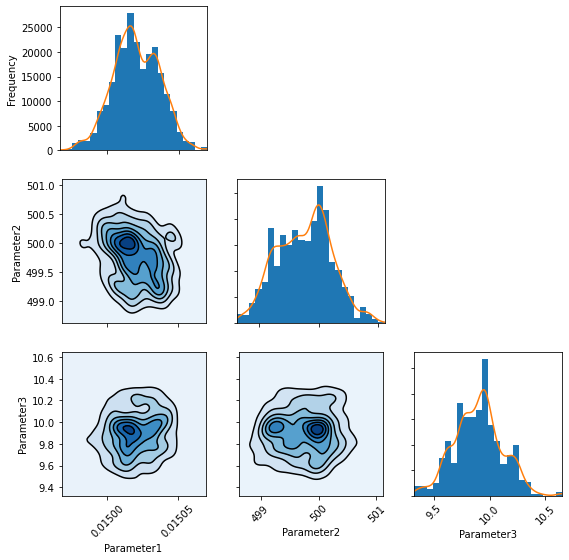

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()

In [2]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.02    0.00    0.01    0.02    0.02    0.02    0.02     1.01    519.56  237.77
k        499.77  0.47    498.91  499.44  499.79  500.09  500.71   1.01    444.65  203.49
sigma    9.91    0.22    9.48    9.75    9.91    10.06   10.34    1.00    533.24  244.03
